In [13]:
from collections import defaultdict
import math
import time
import copy
import itertools
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../runs/vae_{}'.format(datetime.now()))

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
number_epochs = 10
batch_size = 128
learning_rate = 1e-4

# Load data

In [4]:
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../dataset/', transform=transform_image, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
print(f"Number of training images: {len(dataset)}")
print(f"Size of each image: {dataset[0][0].size()}")

Number of training images: 60000
Size of each image: torch.Size([1, 28, 28])


## show some images

In [6]:
def imshow(tensor, ax=None):
    np_img = tensor.permute(1, 2, 0)
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np_img)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


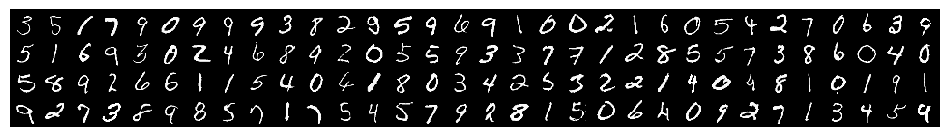

In [7]:
# get some random training images
data_iter = iter(data_loader)
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(batch_size/4))
# write to tensorboard
writer.add_image('mnist', grid)
imshow(grid, ax=ax)

# Create MLP VAE model

In [17]:
class VAE(nn.Module):
    
    def __init__(self, input_size=28, hidden_size=3):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size*input_size, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, input_size*input_size)
        
    def encode_function(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size(), device=device).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decode_function(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode_function(x)
        z = self.reparametrize(mu, logvar)
        return self.decode_function(z), mu, logvar

In [18]:
vae = VAE()
vae

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [19]:
vae(torch.rand(1, 1, 28 * 28))

(tensor([[[0.4204, 0.5427, 0.6325, 0.5114, 0.5153, 0.3480, 0.5611, 0.4884,
           0.4269, 0.5114, 0.5126, 0.3191, 0.5131, 0.6023, 0.5056, 0.5939,
           0.5377, 0.4620, 0.4767, 0.6110, 0.4653, 0.4752, 0.4533, 0.4193,
           0.5293, 0.4653, 0.6142, 0.4959, 0.4945, 0.5074, 0.5020, 0.4634,
           0.4793, 0.4322, 0.5690, 0.4687, 0.4794, 0.5987, 0.5251, 0.5083,
           0.4370, 0.4663, 0.5035, 0.5215, 0.4296, 0.3465, 0.5274, 0.5186,
           0.4467, 0.4695, 0.6050, 0.4663, 0.5426, 0.6172, 0.4182, 0.5032,
           0.5001, 0.5602, 0.4462, 0.5643, 0.5455, 0.4053, 0.4608, 0.4485,
           0.4858, 0.4824, 0.5196, 0.5218, 0.5503, 0.5107, 0.4541, 0.5591,
           0.5064, 0.4705, 0.4767, 0.5118, 0.5788, 0.5370, 0.4424, 0.5322,
           0.4986, 0.5486, 0.4123, 0.5103, 0.4943, 0.5174, 0.5208, 0.4687,
           0.6081, 0.4166, 0.5201, 0.4648, 0.5169, 0.5331, 0.4512, 0.4735,
           0.5091, 0.5188, 0.6453, 0.4684, 0.5595, 0.6009, 0.4927, 0.4829,
           0.5506, 0.5242

In [20]:
# inspect model in tensorboard
writer.add_graph(vae, torch.rand(1, 1, 28 * 28))

In [21]:
def to_image(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def imshow_tensor(inputs):
    grid = torchvision.utils.make_grid(inputs, normalize=True, scale_each=True, nrow=int(batch_size/4))
    fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
    imshow(grid, ax=ax)
    plt.show()
    return fig

In [28]:
def train(model, optimizer, criterion, data_loader, epochs, flatten=True, model_name='mlp'):
    model = model.to(device)
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs+1):        
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            if flatten:
                inputs = inputs.view(inputs.size(0), -1)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(inputs)
            loss = criterion(recon_batch, inputs, mu, logvar)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item()

        batch_size = len(data_loader.dataset)
        epoch_loss = running_loss / batch_size

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, epochs, epoch_loss))
        print('-' * 60)
        # ...log the running loss to tensorboard
        writer.add_scalar('loss/{}'.format(model_name), epoch_loss, epoch)
        
        imgs = to_image(recon_batch.cpu().data)
        fig = imshow_tensor(imgs)
        writer.add_figure('Generated-Image/{}'.format(model_name), fig, epoch)
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model


reconstruction_function = nn.MSELoss(size_average=False)


def loss_fn(reconstruction_x, x, mu, logvar):
    """
    reconstruction_x: generating images
    x: original images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(reconstruction_x, x) 
    # KL loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_aspect = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_aspect).mul_(-0.5)
    # KL divergence
    return BCE + KLD

Epoch [1/20], Loss: 106321.1110
------------------------------------------------------------


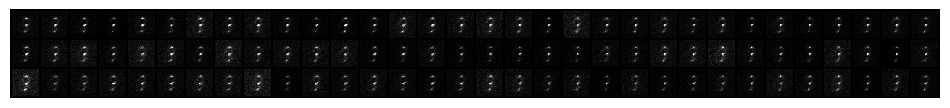

Epoch [2/20], Loss: 94791.8397
------------------------------------------------------------


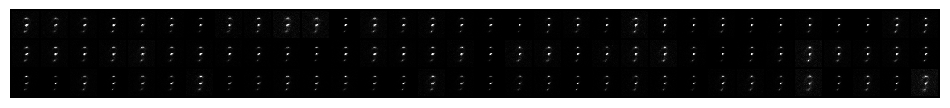

Epoch [3/20], Loss: 93906.2222
------------------------------------------------------------


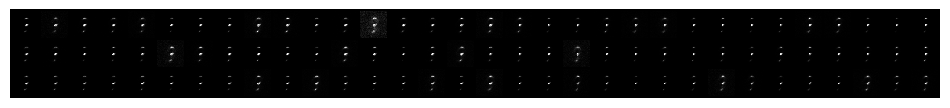

Epoch [4/20], Loss: 93579.5033
------------------------------------------------------------


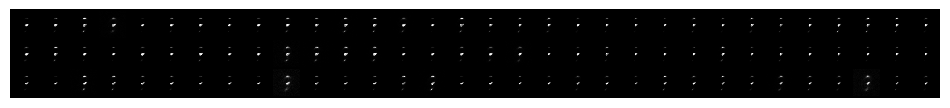

Epoch [5/20], Loss: 93371.6904
------------------------------------------------------------


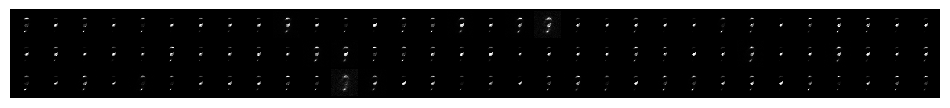

Epoch [6/20], Loss: 93212.5387
------------------------------------------------------------


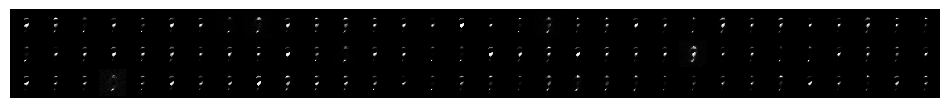

Epoch [7/20], Loss: 93079.9741
------------------------------------------------------------


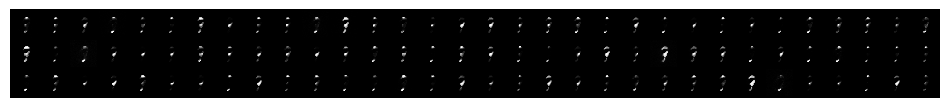

Epoch [8/20], Loss: 92819.3824
------------------------------------------------------------


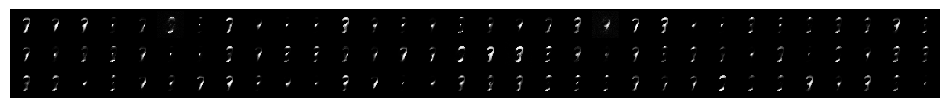

Epoch [9/20], Loss: 92560.2020
------------------------------------------------------------


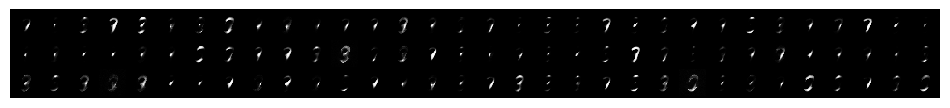

Epoch [10/20], Loss: 92355.2701
------------------------------------------------------------


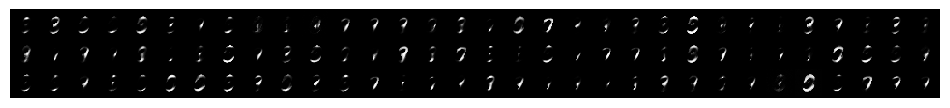

Epoch [11/20], Loss: 92113.5042
------------------------------------------------------------


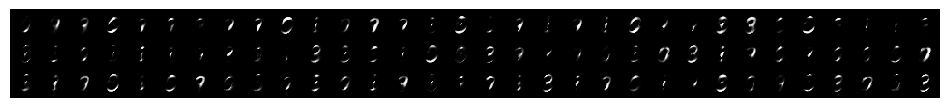

Epoch [12/20], Loss: 91919.4233
------------------------------------------------------------


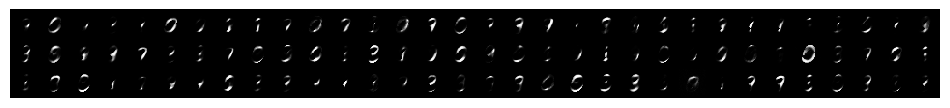

Epoch [13/20], Loss: 91740.7653
------------------------------------------------------------


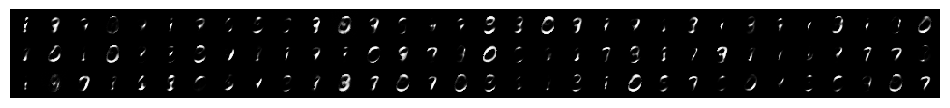

Epoch [14/20], Loss: 91568.9959
------------------------------------------------------------


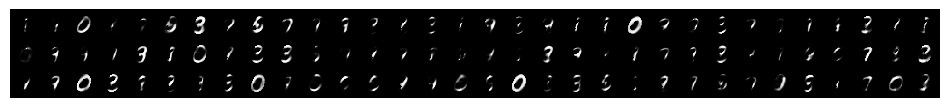

Epoch [15/20], Loss: 91402.0340
------------------------------------------------------------


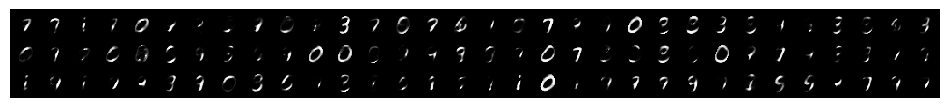

Epoch [16/20], Loss: 91234.3755
------------------------------------------------------------


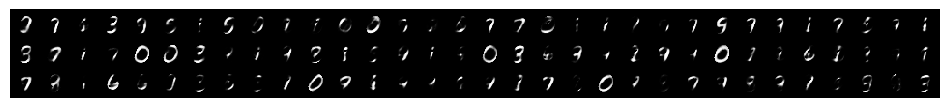

Epoch [17/20], Loss: 91078.2171
------------------------------------------------------------


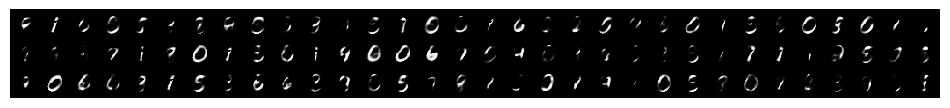

Epoch [18/20], Loss: 90953.8094
------------------------------------------------------------


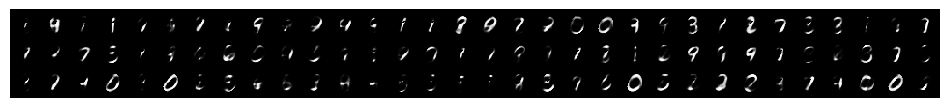

Epoch [19/20], Loss: 90855.5871
------------------------------------------------------------


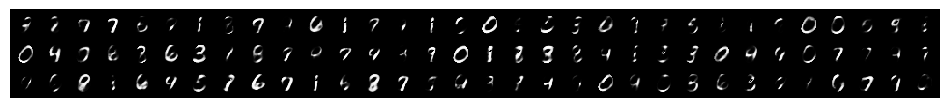

Epoch [20/20], Loss: 90753.5984
------------------------------------------------------------


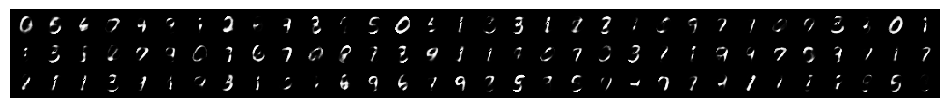

Training complete in 3m 52s


In [30]:
vae = VAE()
criterion = loss_fn
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=1e-5)
m = train(vae, optimizer, criterion, data_loader, 20, model_name='vae')